In [13]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, log_loss
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTENC
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

from category_encoders import TargetEncoder

from sklearn import model_selection

import warnings
warnings.filterwarnings("ignore")

In [46]:
%%time
train_values = pd.read_csv("train_values.csv")
train_labels = pd.read_csv("train_labels.csv")
test_values = pd.read_csv("test_values.csv")

Wall time: 618 ms


In [47]:
# find number of rows and columns
print(
f'train_values shape: {train_values.shape}\n\
train_labels shape: {train_labels.shape}\n\
test_values shape: {test_values.shape}')

train_values shape: (260601, 39)
train_labels shape: (260601, 2)
test_values shape: (86868, 39)


In [48]:
fe = pd.read_csv("./Feature Engineering/new_features.csv")
print(fe.shape)
fe = fe.drop(columns='Unnamed: 0')
fe.head(1)

(260601, 10)


,SS_3_clusterID,SS_6_clusterID,SS_8_clusterID,max_comp,min_comp,mean_comp,max_elas,min_elas,mean_elas
0,cluster2,cluster0,cluster0,2.0,0.75,1.375,1200.0,300.0,750.0


In [49]:
train_values = pd.concat([train_values, fe], axis=1)
test_values = pd.merge(test_values,
                       train_values[['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', \
                 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', \
                 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', \
                 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'SS_3_clusterID', 
                 'SS_6_clusterID', 'SS_8_clusterID']].drop_duplicates(),
                       on=['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', \
                 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', \
                 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', \
                 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered'],
                      how='left')
test_values.shape

(86868, 42)

In [50]:
test_values_cpy = test_values.copy()
test_values_cpy.loc[test_values_cpy['has_superstructure_adobe_mud'] > 0, 'adobe_comp'] = 0.75
#test_values_cpy.loc[test_values_cpy['has_superstructure_adobe_mud'] == 0, 'adobe_comp'] = 0
test_values_cpy.loc[test_values_cpy['has_superstructure_adobe_mud'] > 0, 'adobe_elas'] = 300
#test_values_cpy.loc[test_values_cpy['has_superstructure_adobe_mud'] == 0, 'adobe_elas'] = 0
# mud-stone
test_values_cpy.loc[test_values_cpy['has_superstructure_mud_mortar_stone'] > 0, 'mud-stone_comp'] = 2
#test_values_cpy.loc[test_values_cpy['has_superstructure_mud_mortar_stone'] == 0, 'mud-stone_comp'] = 0
test_values_cpy.loc[test_values_cpy['has_superstructure_mud_mortar_stone'] > 0, 'mud-stone_elas'] = 1200
#test_values_cpy.loc[test_values_cpy['has_superstructure_mud_mortar_stone'] == 0, 'mud-stone_elas'] = 0
# stone (flag)
test_values_cpy.loc[test_values_cpy['has_superstructure_stone_flag'] > 0, 'stone_comp'] = 50
#test_values_cpy.loc[test_values_cpy['has_superstructure_stone_flag'] == 0, 'stone_comp'] = 0
test_values_cpy.loc[test_values_cpy['has_superstructure_stone_flag'] > 0, 'stone_elas'] = 2500
#test_values_cpy.loc[test_values_cpy['has_superstructure_stone_flag'] == 0, 'stone_elas'] = 0
# cement-stone
test_values_cpy.loc[test_values_cpy['has_superstructure_cement_mortar_stone'] > 0, 'cement-stone_comp'] = 40
#test_values_cpy.loc[test_values_cpy['has_superstructure_cement_mortar_stone'] == 0, 'cement-stone_comp'] = 0
test_values_cpy.loc[test_values_cpy['has_superstructure_cement_mortar_stone'] > 0, 'cement-stone_elas'] = 2000
#test_values_cpy.loc[test_values_cpy['has_superstructure_cement_mortar_stone'] == 0, 'cement-stone_elas'] = 0
# mud-brick
test_values_cpy.loc[test_values_cpy['has_superstructure_mud_mortar_brick'] > 0, 'mud-brick_comp'] = 2
#test_values_cpy.loc[test_values_cpy['has_superstructure_mud_mortar_brick'] == 0, 'mud-brick_comp'] = 0
test_values_cpy.loc[test_values_cpy['has_superstructure_mud_mortar_brick'] > 0, 'mud-brick_elas'] = 1000
#test_values_cpy.loc[test_values_cpy['has_superstructure_mud_mortar_brick'] == 0, 'mud-brick_elas'] = 0
# cement-brick
test_values_cpy.loc[test_values_cpy['has_superstructure_cement_mortar_brick'] > 0, 'cement-brick_comp'] = 12
#test_values_cpy.loc[test_values_cpy['has_superstructure_cement_mortar_brick'] == 0, 'cement-brick_comp'] = 0
test_values_cpy.loc[test_values_cpy['has_superstructure_cement_mortar_brick'] > 0, 'cement-brick_elas'] = 6000
#test_values_cpy.loc[test_values_cpy['has_superstructure_cement_mortar_brick'] == 0, 'cement-brick_elas'] = 0
# timber
test_values_cpy.loc[test_values_cpy['has_superstructure_timber'] > 0, 'timber_comp'] = 50
#test_values_cpy.loc[test_values_cpy['has_superstructure_timber'] == 0, 'timber_comp'] = 0
test_values_cpy.loc[test_values_cpy['has_superstructure_timber'] > 0, 'timber_elas'] = 13000
#test_values_cpy.loc[test_values_cpy['has_superstructure_timber'] == 0, 'timber_elas'] = 0
# bamboo
test_values_cpy.loc[test_values_cpy['has_superstructure_bamboo'] > 0, 'bamboo_comp'] = 40
#test_values_cpy.loc[test_values_cpy['has_superstructure_bamboo'] == 0, 'bamboo_comp'] = 0
test_values_cpy.loc[test_values_cpy['has_superstructure_bamboo'] > 0, 'bamboo_elas'] = 15000
#test_values_cpy.loc[test_values_cpy['has_superstructure_bamboo'] == 0, 'bamboo_elas'] = 0
# RC-non-eng
test_values_cpy.loc[test_values_cpy['has_superstructure_rc_non_engineered'] > 0, 'RC-non-eng_comp'] = 30
#test_values_cpy.loc[test_values_cpy['has_superstructure_rc_non_engineered'] == 0, 'RC-non-eng_comp'] = 0
test_values_cpy.loc[test_values_cpy['has_superstructure_rc_non_engineered'] > 0, 'RC-non-eng_elas'] = 20000
#test_values_cpy.loc[test_values_cpy['has_superstructure_rc_non_engineered'] == 0, 'RC-non-eng_elas'] = 0
# RC-eng
test_values_cpy.loc[test_values_cpy['has_superstructure_rc_engineered'] > 0, 'RC-eng_comp'] = 38
#test_values_cpy.loc[test_values_cpy['has_superstructure_rc_engineered'] == 0, 'RC-eng_comp'] = 0
test_values_cpy.loc[test_values_cpy['has_superstructure_rc_engineered'] > 0, 'RC-eng_elas'] = 33000
#test_values_cpy.loc[test_values_cpy['has_superstructure_rc_engineered'] == 0, 'RC-eng_elas'] = 0

In [51]:
test_values_cpy['max_comp'] = test_values_cpy[['adobe_comp', 'mud-stone_comp', 'stone_comp', 'cement-stone_comp', 'mud-brick_comp', 'cement-brick_comp', 'timber_comp', 'bamboo_comp', 'RC-non-eng_comp', 'RC-eng_comp']].max(axis=1)
test_values_cpy['min_comp'] = test_values_cpy[['adobe_comp', 'mud-stone_comp', 'stone_comp', 'cement-stone_comp', 'mud-brick_comp', 'cement-brick_comp', 'timber_comp', 'bamboo_comp', 'RC-non-eng_comp', 'RC-eng_comp']].min(axis=1)
test_values_cpy['mean_comp'] = test_values_cpy[['adobe_comp', 'mud-stone_comp', 'stone_comp', 'cement-stone_comp', 'mud-brick_comp', 'cement-brick_comp', 'timber_comp', 'bamboo_comp', 'RC-non-eng_comp', 'RC-eng_comp']].mean(axis=1)
test_values_cpy['max_elas'] = test_values_cpy[['adobe_elas', 'mud-stone_elas', 'stone_elas', 'cement-stone_elas', 'mud-brick_elas', 'cement-brick_elas', 'timber_elas', 'bamboo_elas', 'RC-non-eng_elas', 'RC-eng_elas']].max(axis=1)
test_values_cpy['min_elas'] = test_values_cpy[['adobe_elas', 'mud-stone_elas', 'stone_elas', 'cement-stone_elas', 'mud-brick_elas', 'cement-brick_elas', 'timber_elas', 'bamboo_elas', 'RC-non-eng_elas', 'RC-eng_elas']].min(axis=1)
test_values_cpy['mean_elas'] = test_values_cpy[['adobe_elas', 'mud-stone_elas', 'stone_elas', 'cement-stone_elas', 'mud-brick_elas', 'cement-brick_elas', 'timber_elas', 'bamboo_elas', 'RC-non-eng_elas', 'RC-eng_elas']].mean(axis=1)


In [52]:
test_values['max_comp'] = test_values_cpy['max_comp']
test_values['min_comp'] = test_values_cpy['min_comp']
test_values['mean_comp'] = test_values_cpy['mean_comp']
test_values['max_elas'] = test_values_cpy['max_elas']
test_values['min_elas'] = test_values_cpy['min_elas']
test_values['mean_elas'] = test_values_cpy['mean_elas']

In [53]:
test_values.shape

(86868, 48)

In [111]:
train_values.iloc[:,-18:-10]

,SS_3_clusterID,SS_6_clusterID,SS_8_clusterID,max_comp,min_comp,mean_comp,max_elas,min_elas
0,cluster2,cluster0,cluster0,2.00,0.75,1.375000,1200.0,300.0
1,cluster2,cluster0,cluster0,2.00,2.00,2.000000,1200.0,1200.0
2,cluster2,cluster0,cluster0,2.00,2.00,2.000000,1200.0,1200.0
3,cluster0,cluster5,cluster1,50.00,2.00,30.666667,15000.0,1200.0
4,cluster1,cluster4,cluster4,0.75,0.75,0.750000,300.0,300.0
...,...,...,...,...,...,...,...,...
260596,cluster2,cluster0,cluster0,2.00,2.00,2.000000,1200.0,1200.0
260597,cluster2,cluster0,cluster0,2.00,2.00,2.000000,1200.0,1200.0
260598,cluster2,cluster0,cluster0,2.00,2.00,2.000000,1200.0,1200.0
260599,cluster1,cluster2,cluster5,12.00,12.00,12.000000,6000.0,6000.0


In [119]:
train_values.min_comp.value_counts()

2.00     199279
0.75      23101
12.00     16558
50.00      7643
40.00      6311
30.00      4728
38.00      2639
Name: min_comp, dtype: int64

In [118]:
train_values.merge(train_labels).groupby(['max_comp']).agg({'damage_grade':'mean'})

,damage_grade
max_comp,
0.75,2.361626
2.00,2.365609
12.00,1.694159
30.00,1.678436
38.00,1.360555
40.00,1.912500
50.00,2.184490


AttributeError: 'AxesSubplot' object has no attribute 'show'

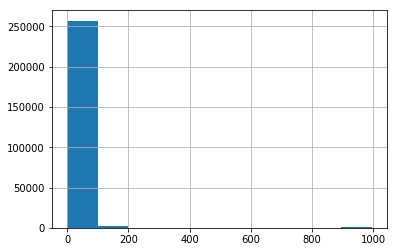

In [140]:
train_values.age.hist()

In [54]:
# look at the last 5 rows
train_values.tail()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_other,SS_3_clusterID,SS_6_clusterID,SS_8_clusterID,max_comp,min_comp,mean_comp,max_elas,min_elas,mean_elas
260596,688636,25,1335,1621,1,55,6,3,n,r,...,0,cluster2,cluster0,cluster0,2.0,2.0,2.0,1200.0,1200.0,1200.0
260597,669485,17,715,2060,2,0,6,5,t,r,...,0,cluster2,cluster0,cluster0,2.0,2.0,2.0,1200.0,1200.0,1200.0
260598,602512,17,51,8163,3,55,6,7,t,r,...,0,cluster2,cluster0,cluster0,2.0,2.0,2.0,1200.0,1200.0,1200.0
260599,151409,26,39,1851,2,10,14,6,t,r,...,0,cluster1,cluster2,cluster5,12.0,12.0,12.0,6000.0,6000.0,6000.0
260600,747594,21,9,9101,3,10,7,6,n,r,...,0,cluster2,cluster0,cluster0,2.0,2.0,2.0,1200.0,1200.0,1200.0


In [55]:
train_labels.tail()

,building_id,damage_grade
260596,688636,2
260597,669485,3
260598,602512,3
260599,151409,2
260600,747594,3


In [56]:
train_values.describe()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,max_comp,min_comp,mean_comp,max_elas,min_elas,mean_elas
count,2.606010e+05,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,...,260601.000000,260601.000000,260601.000000,260601.000000,260259.000000,260259.000000,260259.000000,260259.000000,260259.000000,260259.000000
mean,5.256755e+05,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,...,0.000188,0.000146,0.000088,0.005119,17.677232,5.730030,11.887784,5908.889990,2521.702227,4231.784776
std,3.045450e+05,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,...,0.013711,0.012075,0.009394,0.071364,21.416686,11.074692,14.117718,7057.820134,4616.535848,5240.524227
min,4.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.750000,0.750000,0.750000,300.000000,300.000000,300.000000
25%,2.611900e+05,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,1200.000000,1200.000000,1200.000000
50%,5.257570e+05,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,1200.000000,1200.000000,1200.000000
75%,7.897620e+05,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,50.000000,2.000000,26.000000,13000.000000,1200.000000,7100.000000
max,1.052934e+06,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,50.000000,50.000000,50.000000,33000.000000,33000.000000,33000.000000


In [57]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 48 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             260601 non-null  int64  
 1   geo_level_1_id                          260601 non-null  int64  
 2   geo_level_2_id                          260601 non-null  int64  
 3   geo_level_3_id                          260601 non-null  int64  
 4   count_floors_pre_eq                     260601 non-null  int64  
 5   age                                     260601 non-null  int64  
 6   area_percentage                         260601 non-null  int64  
 7   height_percentage                       260601 non-null  int64  
 8   land_surface_condition                  260601 non-null  object 
 9   foundation_type                         260601 non-null  object 
 10  roof_type                               2606

In [120]:
# find non numerical features (categorical) and their possible values
categ_col = []
for col in train_values.columns:
    if train_values[col].dtypes not in ('int64', 'float64'):
        categ_col.append(col)
        print(train_values[col].value_counts(),'\n')

t    216757
n     35528
o      8316
Name: land_surface_condition, dtype: int64 

r    219196
w     15118
u     14260
i     10579
h      1448
Name: foundation_type, dtype: int64 

n    182842
q     61576
x     16183
Name: roof_type, dtype: int64 

f    209619
x     24877
v     24593
z      1004
m       508
Name: ground_floor_type, dtype: int64 

q    165282
x     43448
j     39843
s     12028
Name: other_floor_type, dtype: int64 

s    202090
t     42896
j     13282
o      2333
Name: position, dtype: int64 

d    250072
q      5692
u      3649
s       346
c       325
a       252
o       159
m        46
n        38
f        22
Name: plan_configuration, dtype: int64 

v    250939
a      5512
w      2677
r      1473
Name: legal_ownership_status, dtype: int64 

cluster2    149795
cluster0     62088
cluster1     48718
Name: SS_3_clusterID, dtype: int64 

cluster0    149795
cluster3     34825
cluster2     28223
cluster4     20495
cluster5     13862
cluster1     13401
Name: SS_6_clusterID, dty

In [59]:
# function to encode categorical features into numerical features to prepare for model fitting

from sklearn.preprocessing import OneHotEncoder

def prepare_inputs(X_train, X_test):
    categ_col_train = X_train.select_dtypes(include=[object]).copy()
    categ_col_test = X_test.select_dtypes(include=[object]).copy()
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    ohe.fit(categ_col_train)
    

    categ_col_test.index = X_test.index
    
    enc_train_categ = pd.DataFrame(ohe.transform(categ_col_train))
    enc_train_categ.index = X_train.index
    X_train_enc = pd.concat([enc_train_categ, X_train.select_dtypes(exclude=[object])], axis=1)
    
    print(f'left table: {enc_train_categ.shape}, right table: {X_train.select_dtypes(exclude=[object]).shape}\
merged table: {X_train_enc.shape}')
    
    enc_test_categ = pd.DataFrame(ohe.transform(categ_col_test))
    enc_test_categ.index = X_test.index
    X_test_enc = pd.concat([enc_test_categ, X_test.select_dtypes(exclude=[object])], axis=1)
   
    print(f'left table: {enc_test_categ.shape}, right table: {X_test.select_dtypes(exclude=[object]).shape}\
merged table: {X_test_enc.shape}')
    return X_train_enc, X_test_enc

In [60]:
# possible values and distributions of the label
train_labels.damage_grade.value_counts()

2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64

In [61]:
%%time
fea = pd.merge(train_values, train_labels, on='building_id')

for col in ['geo_level_1_id', 'geo_level_2_id','geo_level_3_id']:
    damage1 = {}
    damage2 = {}
    damage3 = {}
    for i,j in (train_values[col].value_counts()).iteritems():
        n1 = len(fea[fea['damage_grade']==1][fea[col]==i])
        n2 = len(fea[fea['damage_grade']==2][fea[col]==i])
        n3 = len(fea[fea['damage_grade']==3][fea[col]==i])
        damage1[i] = n1/j
        damage2[i] = n2/j
        damage3[i] = n3/j
    list1 = []
    list2 = []
    list3 = []
    for i in train_values[col]:
        list1.append(damage1.get(i))
        list2.append(damage2.get(i))
        list3.append(damage3.get(i))
    train_values[f'{col}_prob1_geo1'] = list1
    train_values[f'{col}_prob2_geo1'] = list2
    train_values[f'{col}_prob3_geo1'] = list3

Wall time: 17min 14s


In [ ]:
# import category_encoders as ce
# def target_encode_multiclass(X,y): #X,y are pandas df and series
#     y=y.astype(str)   #convert to string to onehot encode
#     enc=ce.OneHotEncoder().fit(y)
#     y_onehot=enc.transform(y)
#     class_names=y_onehot.columns  #names of onehot encoded columns
#     X_obj=X.select_dtypes('object') #separate categorical columns
#     X=X.select_dtypes(exclude='object') 
#     for class_ in class_names:
      
#         enc=ce.TargetEncoder()
#         enc.fit(X_obj,y_onehot[class_]) #convert all categorical 
#         temp=enc.transform(X_obj)       #columns for class_
#         temp.columns=[str(x)+'_'+str(class_) for x in temp.columns]
#         X=pd.concat([X,temp],axis=1)    #add to original dataset
      
#     return X

In [62]:
train_values[['geo_level_1_id_prob1_geo1', 'geo_level_1_id_prob2_geo1', 'geo_level_1_id_prob3_geo1',
             'geo_level_2_id_prob1_geo1', 'geo_level_2_id_prob2_geo1', 'geo_level_2_id_prob3_geo1',
             'geo_level_3_id_prob1_geo1', 'geo_level_3_id_prob2_geo1', 'geo_level_3_id_prob3_geo1']].isnull().any()

geo_level_1_id_prob1_geo1    False
geo_level_1_id_prob2_geo1    False
geo_level_1_id_prob3_geo1    False
geo_level_2_id_prob1_geo1    False
geo_level_2_id_prob2_geo1    False
geo_level_2_id_prob3_geo1    False
geo_level_3_id_prob1_geo1    False
geo_level_3_id_prob2_geo1    False
geo_level_3_id_prob3_geo1    False
dtype: bool

In [121]:
train_values.head(2)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,mean_elas,geo_level_1_id_prob1_geo1,geo_level_1_id_prob2_geo1,geo_level_1_id_prob3_geo1,geo_level_2_id_prob1_geo1,geo_level_2_id_prob2_geo1,geo_level_2_id_prob3_geo1,geo_level_3_id_prob1_geo1,geo_level_3_id_prob2_geo1,geo_level_3_id_prob3_geo1
0,802906,6,487,12198,2,30,6,5,t,r,...,750.0,0.086461,0.665354,0.248185,0.003704,0.251852,0.744444,0.0000,0.162162,0.837838
1,28830,8,900,2812,2,10,8,7,o,r,...,1200.0,0.034277,0.446174,0.519549,0.010050,0.492462,0.497487,0.0625,0.812500,0.125000


# Splitting the Data

In [64]:
# cols_to_drop = ['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

In [122]:
cols_to_drop = ['building_id']

In [123]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_values.drop(columns=cols_to_drop), train_labels['damage_grade'], test_size=0.2, random_state=42)

type(X_train)
type(y_train)

pandas.core.series.Series

In [124]:
print(categ_col)
categ_col_index = [X_train.columns.get_loc(c) for c in categ_col]
print(categ_col_index)

['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status', 'SS_3_clusterID', 'SS_6_clusterID', 'SS_8_clusterID']
[7, 8, 9, 10, 11, 12, 13, 25, 38, 39, 40]


In [125]:
%%time
# rebalance data

rebalance = 0

if rebalance == 1:
    smote = SMOTENC(categorical_features=categ_col_index, random_state=0)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    print(X_resampled.shape)
    print(y_resampled.shape)
    print(y_resampled.value_counts())
else:
    pass

Wall time: 0 ns


In [126]:
# use function prepare_inputs to convert categorical features to numerical features
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)

if rebalance == 1:
    X_train_enc_reb, X_test_enc_reb = prepare_inputs(X_resampled, X_test)

left table: (208480, 55), right table: (208480, 45)merged table: (208480, 100)
left table: (52121, 55), right table: (52121, 45)merged table: (52121, 100)


In [127]:
print(X_train_enc.shape)

if rebalance == 1:
    print(X_train_enc_reb.shape)

(208480, 100)


# XGBoosting

In [133]:
%%time
model = XGBClassifier()
model.fit(X_train_enc, y_train)

Wall time: 43.3 s


In [134]:
y_pred = model.predict(X_test_enc)
predictions = [round(value) for value in y_pred]

In [135]:
class_names = [str(x) for x in model.classes_]
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           1       0.71      0.59      0.64      5170
           2       0.76      0.85      0.80     29487
           3       0.77      0.66      0.71     17464

    accuracy                           0.76     52121
   macro avg       0.75      0.70      0.72     52121
weighted avg       0.76      0.76      0.76     52121



In [136]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1 Score = {:.4f}".format(f1_score(y_test, predictions, average='micro')))

Accuracy: 76.14%
F1 Score = 0.7614


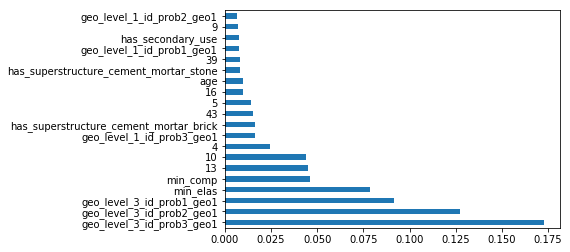

In [145]:
import matplotlib.pyplot as plt
feat_importances = pd.Series(model.feature_importances_, index=X_train_enc.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()


# Stacking

In [ ]:
%%time

rf_param = {'n_estimators': [1000], 
'min_samples_split':[20]}

clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
clf4 = RandomForestClassifier(n_estimators=1000, min_samples_split=20, random_state=0)
clf5 = XGBClassifier()

classifiers=[('DT', clf1), ('SVM', clf3), ('RF', clf4), ('XGB', clf5)]

sclf = StackingClassifier(
    classifiers=[c[1] for c in classifiers], meta_classifier=XGBClassifier(), fit_base_estimators=False,
    use_probas=True, average_probas=False)

print('5-fold cross validation:\n')
for mdl in classifiers+[('Stacking (XGB)', sclf)]:
    
    clf = mdl[1]
    clf = clf.fit(X_train_enc, y_train)

    y_pred = clf.predict(X_test_enc)
    predictions = [round(value) for value in y_pred]
        
    print(f"{mdl[0]}: Micro-Average F1 = {f1_score(y_test, predictions, average='micro')}")


5-fold cross validation:

DT: Micro-Average F1 = 0.7375913739183824


In [42]:
from flaml import AutoML
automl = AutoML()
automl_settings = {
    "time_budget": 600,  # in seconds
    "metric": 'micro_f1',
    "task": 'classification',
    "log_file_name": "EQ.log",
}

In [43]:
automl.fit(X_train=X_train_enc, y_train=y_train.squeeze(),
           **automl_settings)

[flaml.automl: 12-04 23:05:22] {1926} INFO - task = classification
[flaml.automl: 12-04 23:05:22] {1928} INFO - Data split method: stratified
[flaml.automl: 12-04 23:05:22] {1932} INFO - Evaluation method: holdout
[flaml.automl: 12-04 23:05:22] {1999} INFO - Minimizing error metric: 1-micro_f1
[flaml.automl: 12-04 23:05:22] {2051} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 12-04 23:05:22] {2291} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-04 23:05:23] {2405} INFO - Estimated sufficient time budget=119778s. Estimated necessary time budget=2761s.
[flaml.automl: 12-04 23:05:23] {2485} INFO -  at 3.2s,	estimator lgbm's best error=0.2916,	best estimator lgbm's best error=0.2916
[flaml.automl: 12-04 23:05:23] {2291} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-04 23:05:23] {2485} INFO -  at 3.3s,	estimator lgbm's best error=0.2916,	best estimator lgbm's best error=0.2916
[flaml.automl

[flaml.automl: 12-04 23:05:36] {2291} INFO - iteration 36, current learner extra_tree
[flaml.automl: 12-04 23:05:36] {2485} INFO -  at 16.2s,	estimator extra_tree's best error=0.2659,	best estimator lgbm's best error=0.2392
[flaml.automl: 12-04 23:05:36] {2291} INFO - iteration 37, current learner extra_tree
[flaml.automl: 12-04 23:05:36] {2485} INFO -  at 16.6s,	estimator extra_tree's best error=0.2659,	best estimator lgbm's best error=0.2392
[flaml.automl: 12-04 23:05:36] {2291} INFO - iteration 38, current learner rf
[flaml.automl: 12-04 23:05:37] {2485} INFO -  at 16.9s,	estimator rf's best error=0.2669,	best estimator lgbm's best error=0.2392
[flaml.automl: 12-04 23:05:37] {2291} INFO - iteration 39, current learner rf
[flaml.automl: 12-04 23:05:37] {2485} INFO -  at 17.3s,	estimator rf's best error=0.2577,	best estimator lgbm's best error=0.2392
[flaml.automl: 12-04 23:05:37] {2291} INFO - iteration 40, current learner extra_tree
[flaml.automl: 12-04 23:05:37] {2485} INFO -  at 1

[flaml.automl: 12-04 23:06:09] {2485} INFO -  at 49.1s,	estimator xgboost's best error=0.2463,	best estimator lgbm's best error=0.2359
[flaml.automl: 12-04 23:06:09] {2291} INFO - iteration 75, current learner lgbm
[flaml.automl: 12-04 23:06:15] {2485} INFO -  at 55.0s,	estimator lgbm's best error=0.2359,	best estimator lgbm's best error=0.2359
[flaml.automl: 12-04 23:06:15] {2291} INFO - iteration 76, current learner lgbm
[flaml.automl: 12-04 23:06:15] {2485} INFO -  at 55.7s,	estimator lgbm's best error=0.2359,	best estimator lgbm's best error=0.2359
[flaml.automl: 12-04 23:06:15] {2291} INFO - iteration 77, current learner xgboost
[flaml.automl: 12-04 23:06:16] {2485} INFO -  at 56.0s,	estimator xgboost's best error=0.2412,	best estimator lgbm's best error=0.2359
[flaml.automl: 12-04 23:06:16] {2291} INFO - iteration 78, current learner xgboost
[flaml.automl: 12-04 23:06:16] {2485} INFO -  at 56.2s,	estimator xgboost's best error=0.2412,	best estimator lgbm's best error=0.2359
[flam

[flaml.automl: 12-04 23:07:28] {2291} INFO - iteration 112, current learner xgb_limitdepth
[flaml.automl: 12-04 23:07:28] {2485} INFO -  at 128.8s,	estimator xgb_limitdepth's best error=0.2422,	best estimator lgbm's best error=0.2354
[flaml.automl: 12-04 23:07:28] {2291} INFO - iteration 113, current learner xgb_limitdepth
[flaml.automl: 12-04 23:07:29] {2485} INFO -  at 129.1s,	estimator xgb_limitdepth's best error=0.2422,	best estimator lgbm's best error=0.2354
[flaml.automl: 12-04 23:07:29] {2291} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 12-04 23:07:30] {2485} INFO -  at 130.1s,	estimator xgb_limitdepth's best error=0.2422,	best estimator lgbm's best error=0.2354
[flaml.automl: 12-04 23:07:30] {2291} INFO - iteration 115, current learner lgbm
[flaml.automl: 12-04 23:07:44] {2485} INFO -  at 144.7s,	estimator lgbm's best error=0.2354,	best estimator lgbm's best error=0.2354
[flaml.automl: 12-04 23:07:44] {2291} INFO - iteration 116, current learner lgbm
[fl

[flaml.automl: 12-04 23:10:17] {2485} INFO -  at 297.1s,	estimator lgbm's best error=0.2351,	best estimator lgbm's best error=0.2351
[flaml.automl: 12-04 23:10:17] {2291} INFO - iteration 150, current learner lgbm
[flaml.automl: 12-04 23:10:20] {2485} INFO -  at 300.4s,	estimator lgbm's best error=0.2351,	best estimator lgbm's best error=0.2351
[flaml.automl: 12-04 23:10:20] {2291} INFO - iteration 151, current learner rf
[flaml.automl: 12-04 23:10:21] {2485} INFO -  at 301.8s,	estimator rf's best error=0.2458,	best estimator lgbm's best error=0.2351
[flaml.automl: 12-04 23:10:21] {2291} INFO - iteration 152, current learner rf
[flaml.automl: 12-04 23:10:22] {2485} INFO -  at 302.7s,	estimator rf's best error=0.2458,	best estimator lgbm's best error=0.2351
[flaml.automl: 12-04 23:10:22] {2291} INFO - iteration 153, current learner lgbm
[flaml.automl: 12-04 23:10:26] {2485} INFO -  at 306.0s,	estimator lgbm's best error=0.2350,	best estimator lgbm's best error=0.2350
[flaml.automl: 12-0

[flaml.automl: 12-04 23:15:38] {2697} INFO - retrain xgboost for 16.5s
[flaml.automl: 12-04 23:15:38] {2702} INFO - retrained model: XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.8898921703772061, colsample_bynode=1,
              colsample_bytree=0.8957567140796368, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.37578966267010755,
              max_delta_step=0, max_depth=0, max_leaves=6,
              min_child_weight=27.00902061742855, missing=nan,
              monotone_constraints='()', n_estimators=355, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0.9290363411971428, reg_lambda=0.00391598641284312,
              scale_pos_weight=None, subsample=0.819993604947291,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=0)
[flaml.automl:

In [44]:
y_pred = automl.predict(X_test_enc)
predictions = [round(value) for value in y_pred]
class_names = [str(x) for x in automl.classes_]
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           1       0.70      0.58      0.64      5170
           2       0.76      0.85      0.80     29487
           3       0.77      0.66      0.71     17464

    accuracy                           0.76     52121
   macro avg       0.75      0.70      0.72     52121
weighted avg       0.76      0.76      0.76     52121



In [45]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1 Score = {:.4f}".format(f1_score(y_test, predictions, average='micro')))

Accuracy: 75.99%
F1 Score = 0.7599


# make prediction on official test data set

In [97]:
test_values

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,mean_elas,geo_level_1_id_prob1_geo1,geo_level_1_id_prob2_geo1,geo_level_1_id_prob3_geo1,geo_level_2_id_prob1_geo1,geo_level_2_id_prob2_geo1,geo_level_2_id_prob3_geo1,geo_level_3_id_prob1_geo1,geo_level_3_id_prob2_geo1,geo_level_3_id_prob3_geo1
0,300051,17,596,11307,3,20,7,6,t,r,...,1200.000000,0.013066,0.179388,0.807546,0.007194,0.280576,0.712230,0.052632,0.263158,0.684211
1,99355,6,141,11987,2,25,13,5,t,r,...,1200.000000,0.086461,0.665354,0.248185,0.000000,0.819149,0.180851,0.000000,1.000000,0.000000
2,890251,22,19,10044,2,5,4,5,t,r,...,1200.000000,0.129718,0.739603,0.130678,0.000000,0.825000,0.175000,0.000000,0.000000,1.000000
3,745817,26,39,633,1,0,19,3,t,r,...,6000.000000,0.354986,0.559142,0.085872,0.507429,0.452947,0.039624,0.571429,0.419355,0.009217
4,421793,17,289,7970,3,15,8,7,t,r,...,1200.000000,0.013066,0.179388,0.807546,0.005181,0.300518,0.694301,0.000000,0.176471,0.823529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,t,r,...,7100.000000,0.035763,0.766337,0.197900,0.056604,0.764151,0.179245,0.194444,0.750000,0.055556
86864,663567,10,1407,11907,3,25,6,7,n,r,...,1333.333333,0.054848,0.548349,0.396802,0.060519,0.541787,0.397695,0.000000,0.277778,0.722222
86865,1049160,22,1136,7712,1,50,3,3,t,r,...,7100.000000,0.129718,0.739603,0.130678,0.083744,0.812808,0.103448,0.090909,0.909091,0.000000
86866,442785,6,1041,912,2,5,9,5,t,r,...,750.000000,0.086461,0.665354,0.248185,0.065421,0.573209,0.361371,0.090909,0.681818,0.227273


In [98]:
train_values.head(2)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,mean_elas,geo_level_1_id_prob1_geo1,geo_level_1_id_prob2_geo1,geo_level_1_id_prob3_geo1,geo_level_2_id_prob1_geo1,geo_level_2_id_prob2_geo1,geo_level_2_id_prob3_geo1,geo_level_3_id_prob1_geo1,geo_level_3_id_prob2_geo1,geo_level_3_id_prob3_geo1
0,802906,6,487,12198,2,30,6,5,t,r,...,750.0,0.086461,0.665354,0.248185,0.003704,0.251852,0.744444,0.0000,0.162162,0.837838
1,28830,8,900,2812,2,10,8,7,o,r,...,1200.0,0.034277,0.446174,0.519549,0.010050,0.492462,0.497487,0.0625,0.812500,0.125000


In [77]:
%%time
for col in ['geo_level_1_id', 'geo_level_2_id','geo_level_3_id']:
    uniq_v = test_values[col].unique()
    for v1 in uniq_v:
        for v2 in [1,2,3]:
            if v1 in train_values[col].unique():
                test_values.loc[test_values[col]==v1, f'{col}_prob{v2}_geo1'] = \
                    train_values.loc[(train_values[col]==v1),f'{col}_prob{v2}_geo1'].values[0]
            else:
                test_values.loc[test_values[col]==v1, f'{col}_prob{v2}_geo1'] = 0

Wall time: 2min 53s


In [78]:
train_values.loc[(train_values['geo_level_2_id']==6),'geo_level_1_id_prob1_geo1'].values[0]

0.09129967776584318

In [79]:
test_values.loc[(test_values['geo_level_2_id']==6),'geo_level_1_id_prob1_geo1'].values[0]

0.09129967776584318

In [99]:
enc_train, enc_test = prepare_inputs(X_train, test_values.drop(columns=cols_to_drop))

left table: (208480, 55), right table: (208480, 45)merged table: (208480, 100)
left table: (86868, 55), right table: (86868, 45)merged table: (86868, 100)


In [100]:
y_pred_official = model.predict(enc_test)

In [101]:
y_pred_official

array([3, 2, 3, ..., 2, 2, 2], dtype=int64)

In [102]:
submission_file = pd.DataFrame({'building_id':test_values.building_id, 'damage_grade':y_pred_official})
submission_file

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,3
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,3
86865,1049160,2
86866,442785,2


In [103]:
submission_file.to_csv('sibmission_file.csv', index=False)